In [2]:
# Cell 1: Import and Setup  
import torch  
import torch.nn as nn  
from torchvision import models  
import numpy as np  
from torch.utils.data import DataLoader  
from torchvision import datasets, transforms  

DATA_PATH = r"D:\data\data original"  
OUTPUT_DIR = r"D:\data mining\appendix"  
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  

transform = transforms.Compose([  
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])  

dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform)  
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)  

print(f"Device: {DEVICE}")  
print(f"Dataset size: {len(dataset)}") 
class_names = dataset.classes  
print(f"\nDataset: {len(dataset)} images")  
print(f"Classes: {class_names}")  

Device: cpu
Dataset size: 2527

Dataset: 2527 images
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [7]:
# Cell 1.5: Dataset integrity check  
print("\n" + "="*60)  
print("DATASET INTEGRITY CHECK")  
print("="*60)  

# Check for corrupted images  
from PIL import Image  
import warnings  

corrupted_images = []  
for idx, (img_path, label) in enumerate(dataset.samples):  
    try:  
        img = Image.open(img_path)  
        img.verify()  # Verify image integrity  
    except Exception as e:  
        corrupted_images.append((img_path, str(e)))  
        
if corrupted_images:  
    print(f"Warning: Found {len(corrupted_images)} corrupted images")  
    for path, error in corrupted_images[:5]:  
        print(f"  {path}: {error}")  
else:  
    print(" All images are valid")  

# Check class distribution  
from collections import Counter  
class_counts = Counter([label for _, label in dataset.samples])  
print(f"\nClass distribution:")  
for i, name in enumerate(dataset.classes):  
    print(f"  {name}: {class_counts[i]} images ({class_counts[i]/len(dataset)*100:.1f}%)")  

# Check image dimensions  
sample_img, _ = dataset[0]  
print(f"\nSample image shape after transformation: {sample_img.shape}")  
print(f"Expected shape: (3, 224, 224)")  
print("="*60)  



DATASET INTEGRITY CHECK
✓ All images are valid

Class distribution:
  cardboard: 403 images (15.9%)
  glass: 501 images (19.8%)
  metal: 410 images (16.2%)
  paper: 594 images (23.5%)
  plastic: 482 images (19.1%)
  trash: 137 images (5.4%)

Sample image shape after transformation: torch.Size([3, 224, 224])
Expected shape: (3, 224, 224)


In [4]:
# Cell 2: Load Model
from torchvision.models import ResNet18_Weights 
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  
model = nn.Sequential(*list(model.children())[:-1])  
model = model.to(DEVICE)  
model.eval()  



Loading pretrained ResNet18...
 Model loaded without warnings


In [6]:
# Cell 3: Extract Features  
features = []  
labels = []  
with torch.no_grad():  
    for batch_idx, (imgs, lbls) in enumerate(dataloader):  
        imgs = imgs.to(DEVICE)  
        feat = model(imgs).view(imgs.size(0), -1)  
        features.append(feat.cpu().numpy())  
        labels.append(lbls.numpy())   
        if (batch_idx + 1) % 20 == 0:  
            print(f"  Processed {(batch_idx+1)*32}/{len(dataset)} images")  

resnet_features = np.vstack(features)  
true_labels = np.concatenate(labels)  



Extracting features...
  Processed 640/2527 images
  Processed 1280/2527 images
  Processed 1920/2527 images

Feature extraction complete
Feature shape: (2527, 512)
Labels shape: (2527,)


In [8]:
# Cell 4: Save Features  
np.save(f'{OUTPUT_DIR}/resnet_features.npy', resnet_features)  
np.save(f'{OUTPUT_DIR}/true_labels.npy', true_labels)  



Features saved to D:\data mining\appendix
  - resnet_features.npy: (2527, 512)
  - true_labels.npy: (2527,)


Feature statistics:
  Mean: 0.8373
  Std: 0.8531
  Min: 0.0000
  Max: 10.6777


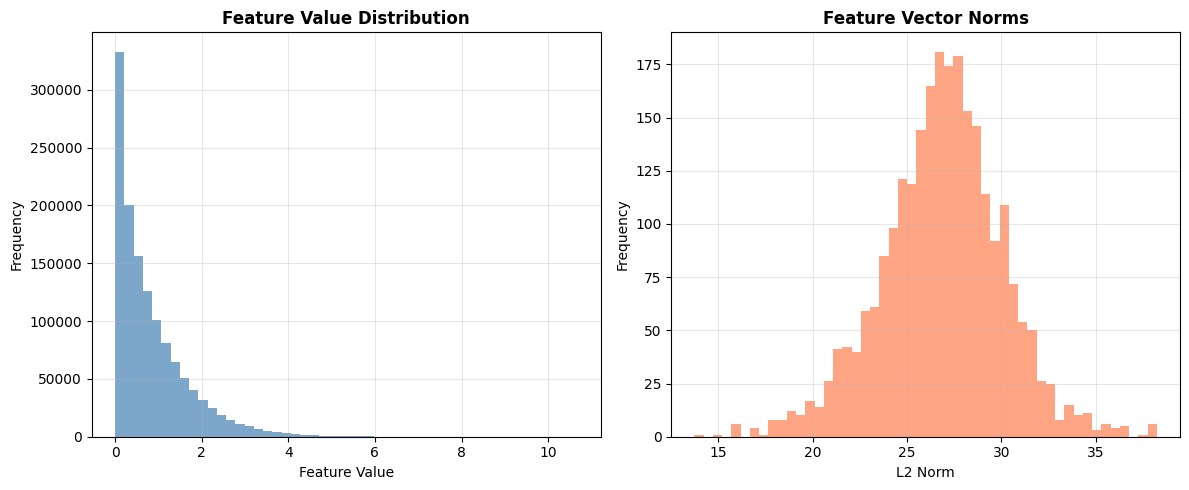

In [9]:
# Cell 5: Feature Statistics  
print("Feature statistics:")  
print(f"  Mean: {resnet_features.mean():.4f}")  
print(f"  Std: {resnet_features.std():.4f}")  
print(f"  Min: {resnet_features.min():.4f}")  
print(f"  Max: {resnet_features.max():.4f}")  

# Visualize feature distribution  
import matplotlib.pyplot as plt  

plt.figure(figsize=(12, 5))  

plt.subplot(1, 2, 1)  
plt.hist(resnet_features.flatten(), bins=50, color='steelblue', alpha=0.7)  
plt.title('Feature Value Distribution', fontsize=12, fontweight='bold')  
plt.xlabel('Feature Value')  
plt.ylabel('Frequency')  
plt.grid(alpha=0.3)  

plt.subplot(1, 2, 2)  
feature_norms = np.linalg.norm(resnet_features, axis=1)  
plt.hist(feature_norms, bins=50, color='coral', alpha=0.7)  
plt.title('Feature Vector Norms', fontsize=12, fontweight='bold')  
plt.xlabel('L2 Norm')  
plt.ylabel('Frequency')  
plt.grid(alpha=0.3)  

plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/02_feature_statistics.png', dpi=300, bbox_inches='tight')  
plt.show()  


In [10]:
# Save true labels  
np.save(f'{OUTPUT_DIR}/true_labels.npy', true_labels)  
# Save class names (for consistent labeling across notebooks)  
class_names = dataset.classes  
np.save(f'{OUTPUT_DIR}/class_names.npy', np.array(class_names, dtype=object))   

[2/4] true_labels.npy
      Shape: (2527,)
      Unique labels: [0 1 2 3 4 5]
[4/4] class_names.npy
      Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [11]:
# Cell 6: Basic Feature Statistics  
print("\n" + "="*60)  
print("FEATURE STATISTICS")  
print("="*60)  

print(f"Mean: {resnet_features.mean():.4f}")  
print(f"Std: {resnet_features.std():.4f}")  
print(f"Min: {resnet_features.min():.4f}")  
print(f"Max: {resnet_features.max():.4f}")  

# Feature norms  
feature_norms = np.linalg.norm(resnet_features, axis=1)  
print(f"\nL2 Norm statistics:")  
print(f"  Mean: {feature_norms.mean():.4f}")  
print(f"  Std: {feature_norms.std():.4f}")  
print(f"  Range: [{feature_norms.min():.4f}, {feature_norms.max():.4f}]")  

# Check for invalid values  
nan_count = np.isnan(resnet_features).sum()  
inf_count = np.isinf(resnet_features).sum()  
print(f"\nData quality check:")  
print(f"  NaN values: {nan_count}")  
print(f"  Inf values: {inf_count}")  
if nan_count == 0 and inf_count == 0:  
    print("  No invalid values found")  
else:  
    print("  Warning: Invalid values detected!")  

# Feature variance analysis  
feature_variance = np.var(resnet_features, axis=0)  
zero_variance_dims = np.sum(feature_variance < 1e-6)  
print(f"\nFeature dimensionality:")  
print(f"  Total dimensions: 512")  
print(f"  Near-zero variance dimensions: {zero_variance_dims}")  
print(f"  Effective dimensions: {512 - zero_variance_dims}")  

print("="*60)  


FEATURE STATISTICS
Mean: 0.8373
Std: 0.8531
Min: 0.0000
Max: 10.6777

L2 Norm statistics:
  Mean: 26.8535
  Std: 3.2339
  Range: [13.7233, 38.2465]

Data quality check:
  NaN values: 0
  Inf values: 0
  No invalid values found

Feature dimensionality:
  Total dimensions: 512
  Near-zero variance dimensions: 0
  Effective dimensions: 512



CLASS-WISE FEATURE ANALYSIS
cardboard:
  Mean norm: 25.0486
  Std norm: 3.4968
  Range: [13.7233, 33.5626]
glass:
  Mean norm: 27.8832
  Std norm: 2.9599
  Range: [20.1811, 38.2087]
metal:
  Mean norm: 27.3077
  Std norm: 2.8423
  Range: [18.6690, 36.6893]
paper:
  Mean norm: 26.0073
  Std norm: 3.0832
  Range: [15.7900, 35.9316]
plastic:
  Mean norm: 27.8337
  Std norm: 3.0396
  Range: [17.6982, 38.2465]
trash:
  Mean norm: 27.2584
  Std norm: 2.5036
  Range: [18.7994, 33.5441]


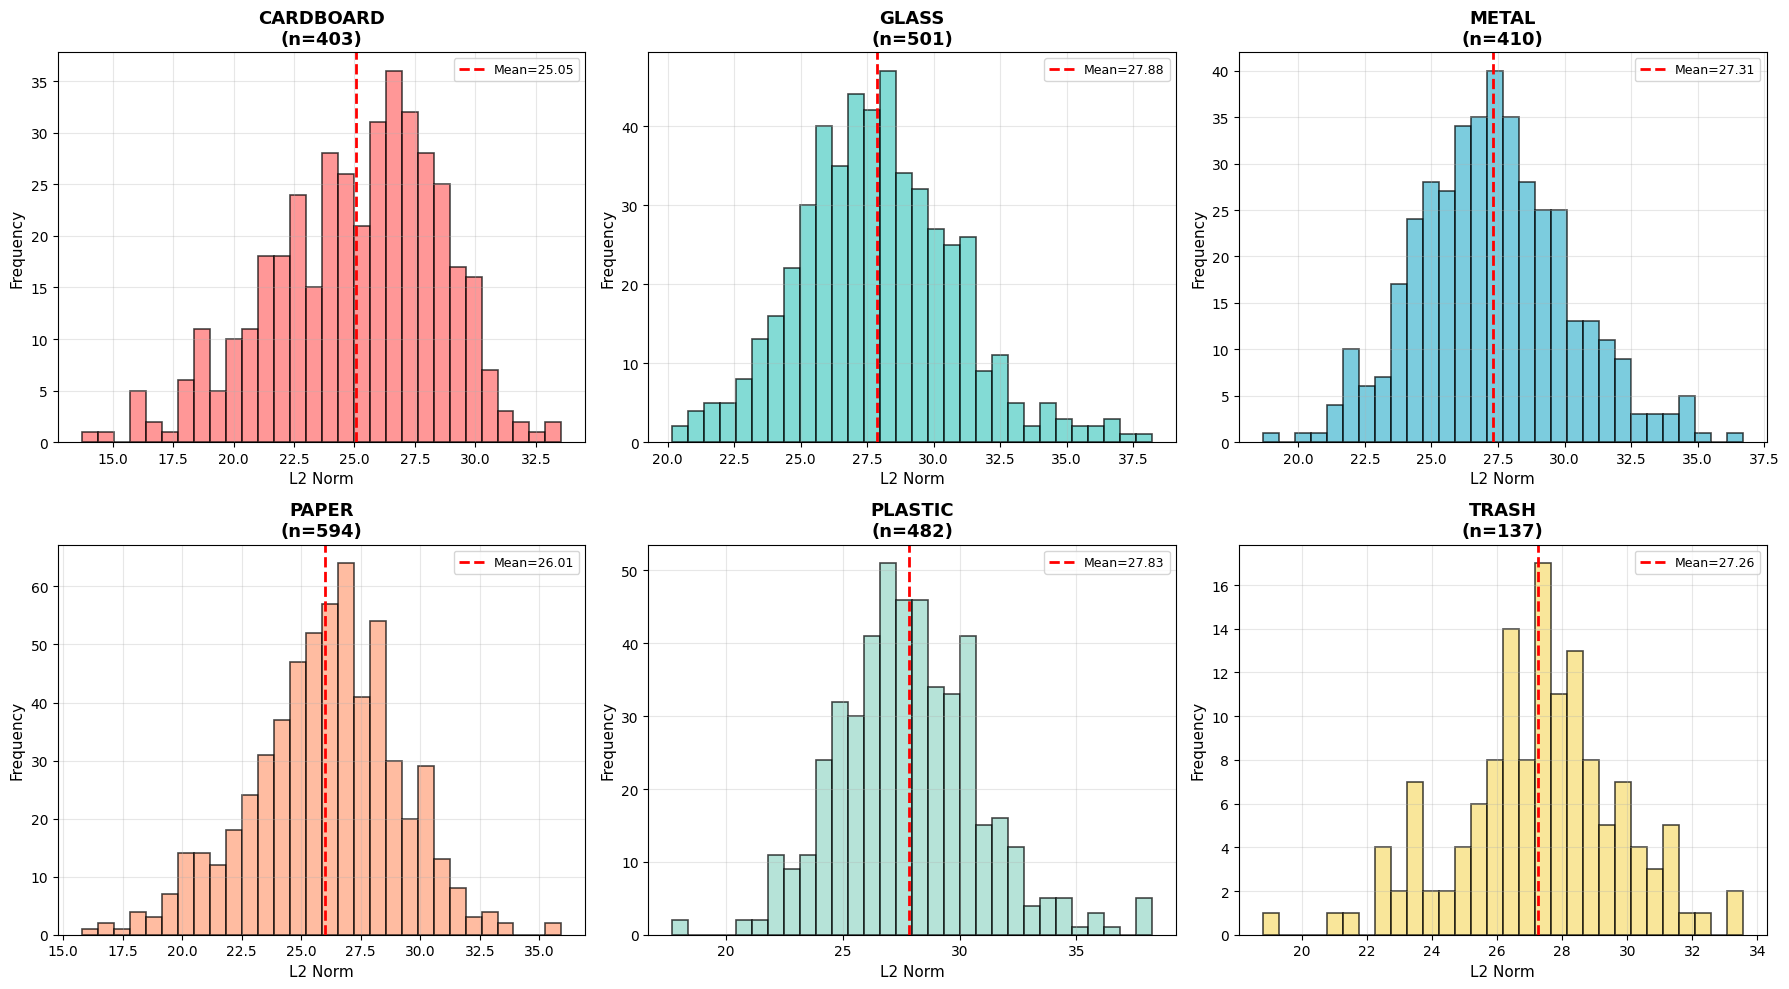


 Class-wise visualization saved: 02_classwise_feature_norms.png


In [12]:
# Cell 7: Class-wise Feature Analysis  
print("\n" + "="*60)  
print("CLASS-WISE FEATURE ANALYSIS")  
print("="*60)  

# Create 2x3 subplots for each class  
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  
axes = axes.flatten()  

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']  

for i, (class_name, color) in enumerate(zip(class_names, colors)):  
    # Get features for this class  
    class_mask = true_labels == i  
    class_features = resnet_features[class_mask]  
    
    # Calculate L2 norms  
    class_norms = np.linalg.norm(class_features, axis=1)  
    
    # Plot histogram  
    axes[i].hist(class_norms, bins=30, color=color, alpha=0.7,   
                 edgecolor='black', linewidth=1.2)  
    axes[i].set_title(f'{class_name.upper()}\n(n={len(class_features)})',   
                      fontsize=13, fontweight='bold')  
    axes[i].set_xlabel('L2 Norm', fontsize=11)  
    axes[i].set_ylabel('Frequency', fontsize=11)  
    axes[i].grid(alpha=0.3)  
    
    # Add mean line  
    mean_norm = class_norms.mean()  
    std_norm = class_norms.std()  
    axes[i].axvline(mean_norm, color='red', linestyle='--',   
                    linewidth=2, label=f'Mean={mean_norm:.2f}')  
    axes[i].legend(fontsize=9)  
    
    # Print statistics  
    print(f"{class_name}:")  
    print(f"  Mean norm: {mean_norm:.4f}")  
    print(f"  Std norm: {std_norm:.4f}")  
    print(f"  Range: [{class_norms.min():.4f}, {class_norms.max():.4f}]")  

plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/02_classwise_feature_norms.png',   
            dpi=300, bbox_inches='tight')  
plt.show()  

print(f"\n Class-wise visualization saved: 02_classwise_feature_norms.png")  
print("="*60)  



FEATURE SPACE SEPARABILITY ANALYSIS


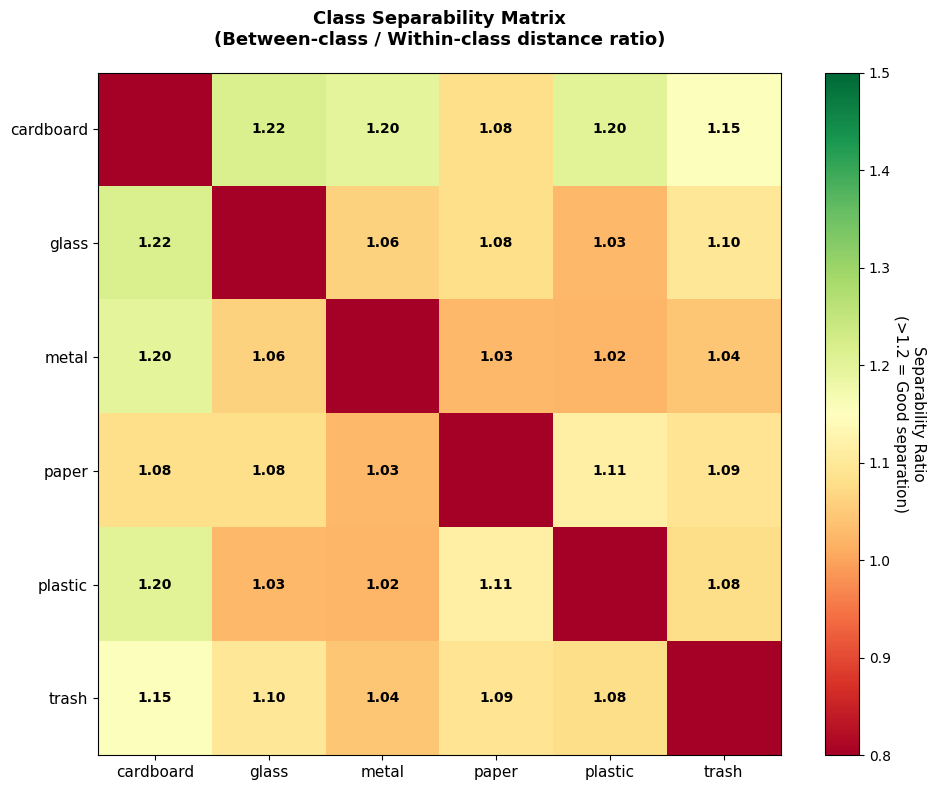


Top 5 Most Separable Class Pairs (Easy to distinguish):
  cardboard vs glass: 1.217
  cardboard vs plastic: 1.204
  cardboard vs metal: 1.197
  cardboard vs trash: 1.153
  paper vs plastic: 1.115

Top 5 Least Separable Class Pairs (Most confusing):
  glass vs metal: 1.060
  metal vs trash: 1.045
  metal vs paper: 1.026
  glass vs plastic: 1.026
  metal vs plastic: 1.024

 Separability analysis saved: 02_separability_matrix.png


In [13]:
# Cell 8: Feature Space Separability Analysis  
from sklearn.metrics import pairwise_distances  

print("\n" + "="*60)  
print("FEATURE SPACE SEPARABILITY ANALYSIS")  
print("="*60)  

# Calculate class centroids  
class_centroids = np.zeros((len(class_names), 512))  
for i in range(len(class_names)):  
    class_mask = true_labels == i  
    class_centroids[i] = resnet_features[class_mask].mean(axis=0)  

# Calculate within-class and between-class distances  
separability_results = []  

for i, class_name_i in enumerate(class_names):  
    class_i_mask = true_labels == i  
    class_i_features = resnet_features[class_i_mask]  
    
    # Within-class distance  
    within_dist = pairwise_distances(class_i_features).mean()  
    
    # Between-class distances  
    for j, class_name_j in enumerate(class_names):  
        if i < j:  
            class_j_mask = true_labels == j  
            class_j_features = resnet_features[class_j_mask]  
            
            between_dist = pairwise_distances(  
                class_i_features, class_j_features  
            ).mean()  
            
            separability_ratio = between_dist / within_dist  
            
            separability_results.append({  
                'class_pair': f'{class_name_i} vs {class_name_j}',  
                'within_dist_i': within_dist,  
                'between_dist': between_dist,  
                'separability': separability_ratio  
            })  

# Create separability matrix  
n_classes = len(class_names)  
separability_matrix = np.zeros((n_classes, n_classes))  

for result in separability_results:  
    pair = result['class_pair'].split(' vs ')  
    i = class_names.index(pair[0])  
    j = class_names.index(pair[1])  
    separability_matrix[i, j] = result['separability']  
    separability_matrix[j, i] = result['separability']  

# Visualize separability matrix  
fig, ax = plt.subplots(figsize=(10, 8))  
im = ax.imshow(separability_matrix, cmap='RdYlGn', vmin=0.8, vmax=1.5)  

# Add text annotations  
for i in range(n_classes):  
    for j in range(n_classes):  
        if i != j:  
            text = ax.text(j, i, f'{separability_matrix[i, j]:.2f}',  
                          ha="center", va="center", color="black",   
                          fontsize=10, fontweight='bold')  

ax.set_xticks(np.arange(n_classes))  
ax.set_yticks(np.arange(n_classes))  
ax.set_xticklabels(class_names, fontsize=11)  
ax.set_yticklabels(class_names, fontsize=11)  
ax.set_title('Class Separability Matrix\n(Between-class / Within-class distance ratio)',   
             fontsize=13, fontweight='bold', pad=20)  

# Colorbar  
cbar = plt.colorbar(im, ax=ax)  
cbar.set_label('Separability Ratio\n(>1.2 = Good separation)',   
               rotation=270, labelpad=25, fontsize=11)  

plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/02_separability_matrix.png',   
            dpi=300, bbox_inches='tight')  
plt.show()  

# Print analysis results  
separability_results.sort(key=lambda x: x['separability'], reverse=True)  

print("\nTop 5 Most Separable Class Pairs (Easy to distinguish):")  
for result in separability_results[:5]:  
    print(f"  {result['class_pair']}: {result['separability']:.3f}")  

print("\nTop 5 Least Separable Class Pairs (Most confusing):")  
for result in separability_results[-5:]:  
    print(f"  {result['class_pair']}: {result['separability']:.3f}")  

print("\n Separability analysis saved: 02_separability_matrix.png")  
print("="*60)  

In [16]:
# Cell 9: Generate Summary Report  
# Save image paths (required for Notebook 8 outlier visualization)  
image_paths = [path for path, _ in dataset.samples]  
np.save(f'{OUTPUT_DIR}/image_paths.npy', np.array(image_paths, dtype=object))  
print(f" image_paths.npy")  
print(f"      Total paths: {len(image_paths)}")  
print(f"      Sample: {image_paths[0]}")  
print("\n" + "="*60)  
print("FEATURE EXTRACTION SUMMARY REPORT")  
print("="*60)  

summary = f"""  
Dataset Information:  
  - Total images: {len(dataset)}  
  - Number of classes: {len(dataset.classes)}  
  - Classes: {', '.join(dataset.classes)}  
  - Most frequent class: {dataset.classes[max(class_counts, key=class_counts.get)]} ({max(class_counts.values())} images)  
  - Least frequent class: {dataset.classes[min(class_counts, key=class_counts.get)]} ({min(class_counts.values())} images)  
 

Feature Extraction:  
  - Model: ResNet18 (ImageNet pretrained)  
  - Feature dimension: 512  
  - Feature shape: {resnet_features.shape}  
  - Device used: {DEVICE}  

Feature Statistics:  
  - Mean: {resnet_features.mean():.4f}  
  - Std: {resnet_features.std():.4f}  
  - Min: {resnet_features.min():.4f}  
  - Max: {resnet_features.max():.4f}  
  - L2 norm range: [{feature_norms.min():.4f}, {feature_norms.max():.4f}]  

Data Quality:  
  - NaN values: {nan_count}  
  - Inf values: {inf_count}  
  - Status: {'Clean' if nan_count == 0 and inf_count == 0 else '⚠ Issues detected'}  

Saved Files:  
  - resnet_features.npy: {resnet_features.shape}  
  - true_labels.npy: {true_labels.shape}  
  - image_paths.npy: {len(image_paths)} paths  
  - class_names.npy: {len(class_names)} classes  

Generated Visualizations:  
  - 02_feature_statistics.png  
  - 02_classwise_feature_norms.png  
  - 02_separability_matrix.png  
  
Next Steps:  
   Notebook 3: UMAP dimensionality reduction  
   Notebook 4: K-Means, GMM, Spectral clustering  
   Notebook 5: Confusion matrix analysis  
   Notebook 8: Outlier detection and visualization  
"""  

print(summary)  
print("="*60)  

# Save summary to text file  
with open(f'{OUTPUT_DIR}/02_extraction_summary.txt', 'w', encoding='utf-8') as f:  
    f.write(summary)  
print(f"\n Summary saved to {OUTPUT_DIR}/02_extraction_summary.txt")  
print("\n" + "="*60)  
print("="*60)  

[3/4] image_paths.npy
      Total paths: 2527
      Sample: D:\data\data original\cardboard\cardboard1.jpg

FEATURE EXTRACTION SUMMARY REPORT
  
Dataset Information:  
  - Total images: 2527  
  - Number of classes: 6  
  - Classes: cardboard, glass, metal, paper, plastic, trash  
  - Most frequent class: paper (594 images)  
  - Least frequent class: trash (137 images)  
 

Feature Extraction:  
  - Model: ResNet18 (ImageNet pretrained)  
  - Feature dimension: 512  
  - Feature shape: (2527, 512)  
  - Device used: cpu  

Feature Statistics:  
  - Mean: 0.8373  
  - Std: 0.8531  
  - Min: 0.0000  
  - Max: 10.6777  
  - L2 norm range: [13.7233, 38.2465]  

Data Quality:  
  - NaN values: 0  
  - Inf values: 0  
  - Status: Clean  

Saved Files:  
  - resnet_features.npy: (2527, 512)  
  - true_labels.npy: (2527,)  
  - image_paths.npy: 2527 paths  
  - class_names.npy: 6 classes  

Generated Visualizations:  
  - 02_feature_statistics.png  
  - 02_classwise_feature_norms.png  
  - 02


CLASS CENTROID SIMILARITY ANALYSIS


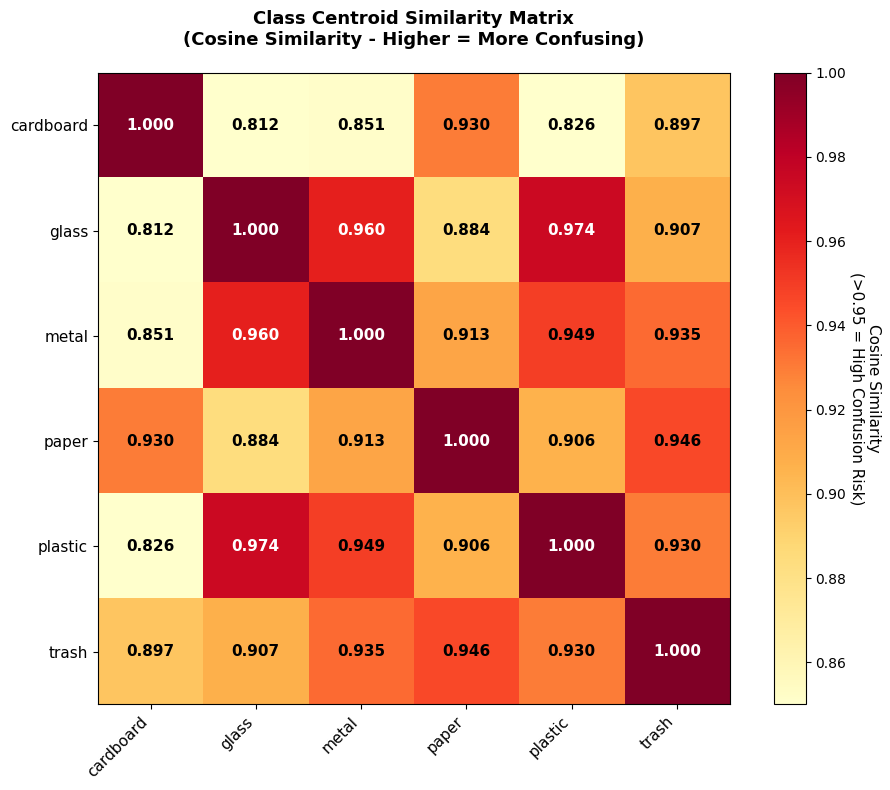


Top 5 Most Similar Class Pairs (Highest Confusion Risk):
  glass vs plastic: 0.9739
  glass vs metal: 0.9603
  metal vs plastic: 0.9491
  paper vs trash: 0.9459
  metal vs trash: 0.9351

Top 5 Least Similar Class Pairs (Easiest to Distinguish):
  cardboard vs trash: 0.8970
  glass vs paper: 0.8835
  cardboard vs metal: 0.8513
  cardboard vs plastic: 0.8255
  cardboard vs glass: 0.8121

 Similarity analysis saved: 02_class_similarity.png


In [17]:
# Cell 10: Class Centroid Similarity Analysis  
from sklearn.metrics.pairwise import cosine_similarity  

print("\n" + "="*60)  
print("CLASS CENTROID SIMILARITY ANALYSIS")  
print("="*60)  

# Calculate class centroids (already done in Cell 9)  
# class_centroids shape: (6, 512)  

# Calculate cosine similarity between centroids  
similarity_matrix = cosine_similarity(class_centroids)  

# Visualize  
fig, ax = plt.subplots(figsize=(10, 8))  
im = ax.imshow(similarity_matrix, cmap='YlOrRd', vmin=0.85, vmax=1.0)  

# Add annotations  
for i in range(len(class_names)):  
    for j in range(len(class_names)):  
        text_color = "white" if similarity_matrix[i, j] > 0.95 else "black"  
        text = ax.text(j, i, f'{similarity_matrix[i, j]:.3f}',  
                      ha="center", va="center",   
                      color=text_color,  
                      fontsize=11, fontweight='bold')  

ax.set_xticks(np.arange(len(class_names)))  
ax.set_yticks(np.arange(len(class_names)))  
ax.set_xticklabels(class_names, fontsize=11, rotation=45, ha='right')  
ax.set_yticklabels(class_names, fontsize=11)  
ax.set_title('Class Centroid Similarity Matrix\n(Cosine Similarity - Higher = More Confusing)',   
             fontsize=13, fontweight='bold', pad=20)  

# Colorbar  
cbar = plt.colorbar(im, ax=ax)  
cbar.set_label('Cosine Similarity\n(>0.95 = High Confusion Risk)',   
               rotation=270, labelpad=25, fontsize=11)  

plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/02_class_similarity.png',   
            dpi=300, bbox_inches='tight')  
plt.show()  

# Find most similar pairs (excluding diagonal)  
np.fill_diagonal(similarity_matrix, 0)  
most_similar_pairs = []  
for i in range(len(class_names)):  
    for j in range(i+1, len(class_names)):  
        most_similar_pairs.append({  
            'pair': f'{class_names[i]} vs {class_names[j]}',  
            'similarity': similarity_matrix[i, j]  
        })  

most_similar_pairs.sort(key=lambda x: x['similarity'], reverse=True)  

print("\nTop 5 Most Similar Class Pairs (Highest Confusion Risk):")  
for pair in most_similar_pairs[:5]:  
    print(f"  {pair['pair']}: {pair['similarity']:.4f}")  

print("\nTop 5 Least Similar Class Pairs (Easiest to Distinguish):")  
for pair in most_similar_pairs[-5:]:  
    print(f"  {pair['pair']}: {pair['similarity']:.4f}")  

print("\n Similarity analysis saved: 02_class_similarity.png")  
print("="*60) 


FEATURE DIMENSION IMPORTANCE ANALYSIS


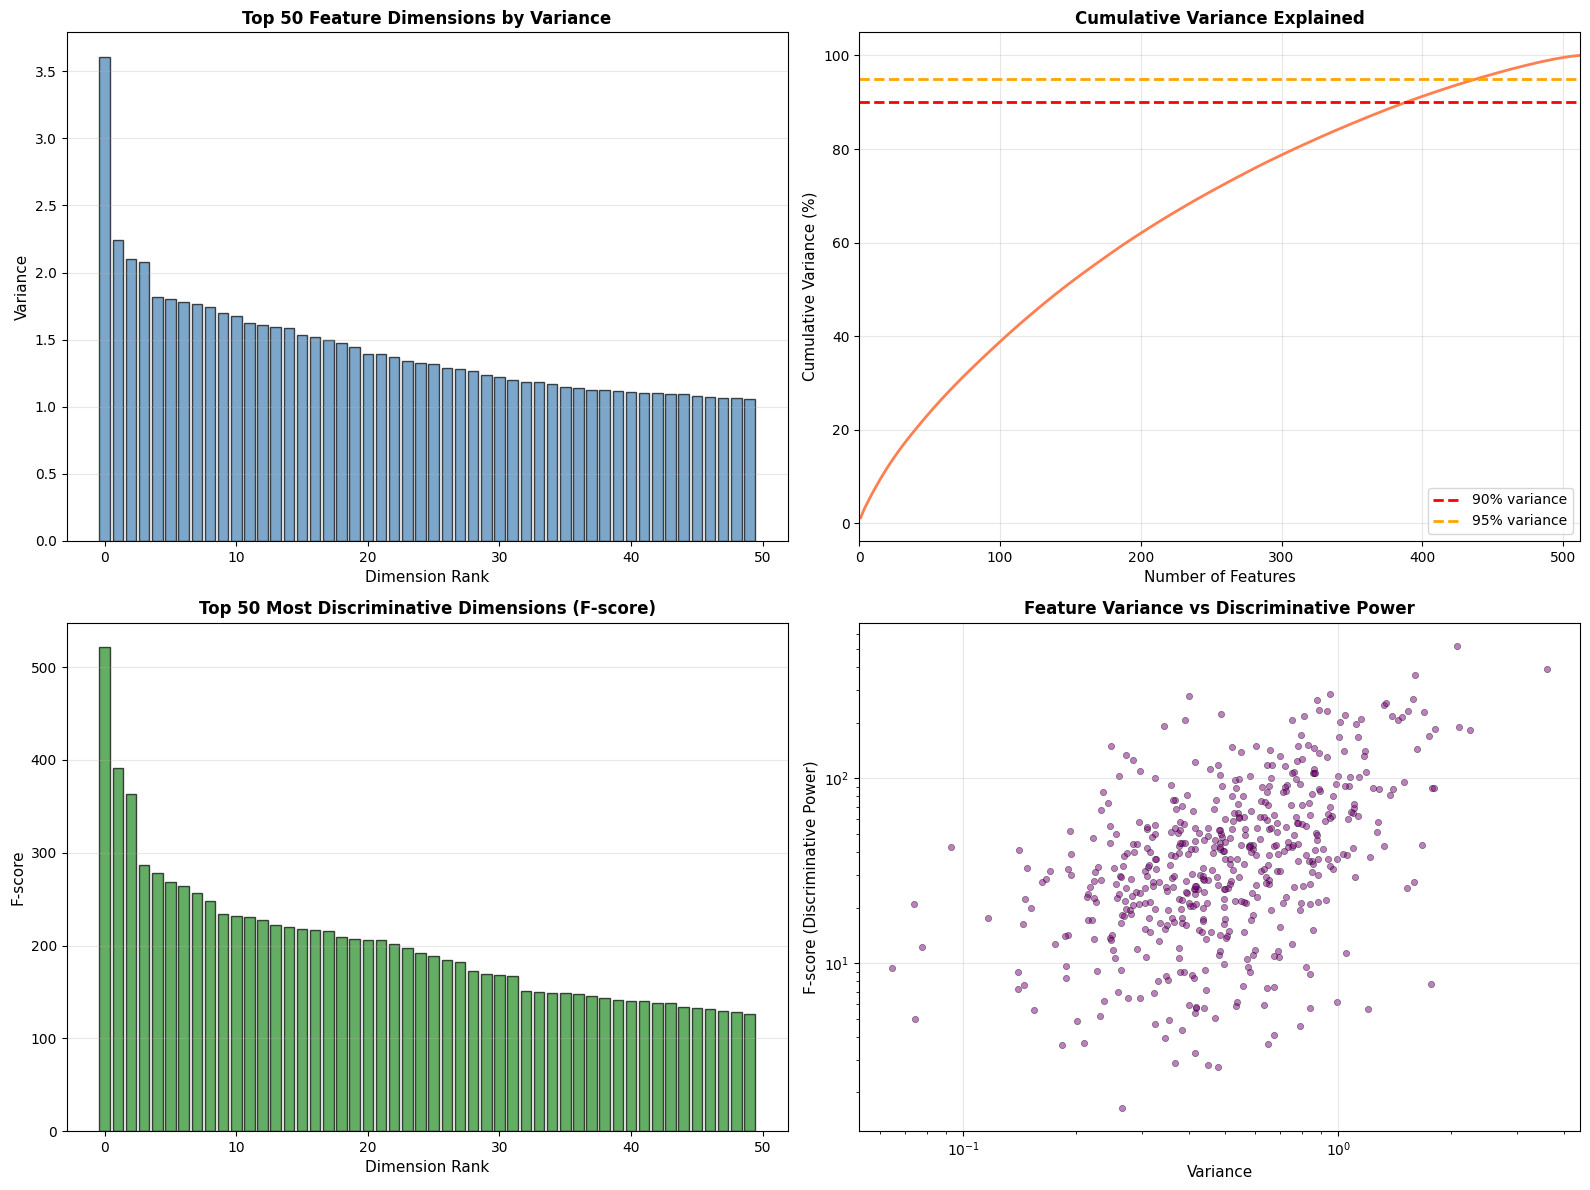


Dimensionality Analysis:
  Dimensions for 90% variance: 389/512 (76.0%)
  Dimensions for 95% variance: 439/512 (85.7%)
  Effective dimensionality: 389 dimensions

Redundancy Analysis:
  Near-zero variance dimensions: 0/512
  Low variance dimensions (bottom 10%): 52/512

Dimension Quality:
  Overlap between top variance & discriminative: 21/50
  Interpretation: Moderate quality

 Feature importance saved: 02_feature_importance.png


In [18]:
# Cell 11: Feature Dimension Importance Analysis  
print("\n" + "="*60)  
print("FEATURE DIMENSION IMPORTANCE ANALYSIS")  
print("="*60)  

# Calculate variance for each feature dimension  
feature_variance = np.var(resnet_features, axis=0)  

# Sort dimensions by variance  
top_k = 50  
top_indices = np.argsort(feature_variance)[-top_k:][::-1]  
top_variances = feature_variance[top_indices]  

# Calculate class discriminative power for each dimension  
from sklearn.feature_selection import f_classif  
f_scores, p_values = f_classif(resnet_features, true_labels)  

# Find most discriminative dimensions  
top_discriminative = np.argsort(f_scores)[-top_k:][::-1]  

# Visualize  
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  

# Plot 1: Top 50 dimensions by variance  
axes[0, 0].bar(range(top_k), top_variances, color='steelblue',   
               edgecolor='black', alpha=0.7)  
axes[0, 0].set_title('Top 50 Feature Dimensions by Variance',   
                     fontsize=12, fontweight='bold')  
axes[0, 0].set_xlabel('Dimension Rank', fontsize=11)  
axes[0, 0].set_ylabel('Variance', fontsize=11)  
axes[0, 0].grid(alpha=0.3, axis='y')  

# Plot 2: Cumulative variance explained  
sorted_variances = np.sort(feature_variance)[::-1]  
cumulative_variance = np.cumsum(sorted_variances) / np.sum(sorted_variances) * 100  

axes[0, 1].plot(range(1, len(cumulative_variance) + 1),   
                cumulative_variance, color='coral', linewidth=2)  
axes[0, 1].axhline(90, color='red', linestyle='--',   
                   linewidth=2, label='90% variance')  
axes[0, 1].axhline(95, color='orange', linestyle='--',   
                   linewidth=2, label='95% variance')  
axes[0, 1].set_title('Cumulative Variance Explained',   
                     fontsize=12, fontweight='bold')  
axes[0, 1].set_xlabel('Number of Features', fontsize=11)  
axes[0, 1].set_ylabel('Cumulative Variance (%)', fontsize=11)  
axes[0, 1].legend(fontsize=10)  
axes[0, 1].grid(alpha=0.3)  
axes[0, 1].set_xlim([0, 512])  

# Plot 3: Top discriminative dimensions  
axes[1, 0].bar(range(top_k), f_scores[top_discriminative],   
               color='forestgreen', edgecolor='black', alpha=0.7)  
axes[1, 0].set_title('Top 50 Most Discriminative Dimensions (F-score)',   
                     fontsize=12, fontweight='bold')  
axes[1, 0].set_xlabel('Dimension Rank', fontsize=11)  
axes[1, 0].set_ylabel('F-score', fontsize=11)  
axes[1, 0].grid(alpha=0.3, axis='y')  

# Plot 4: Variance vs Discriminative power scatter  
axes[1, 1].scatter(feature_variance, f_scores, alpha=0.5,   
                   color='purple', s=20, edgecolor='black', linewidth=0.5)  
axes[1, 1].set_title('Feature Variance vs Discriminative Power',   
                     fontsize=12, fontweight='bold')  
axes[1, 1].set_xlabel('Variance', fontsize=11)  
axes[1, 1].set_ylabel('F-score (Discriminative Power)', fontsize=11)  
axes[1, 1].grid(alpha=0.3)  
axes[1, 1].set_xscale('log')  
axes[1, 1].set_yscale('log')  

plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/02_feature_importance.png',   
            dpi=300, bbox_inches='tight')  
plt.show()  

# Calculate effective dimensionality  
n_dims_90 = np.argmax(cumulative_variance >= 90) + 1  
n_dims_95 = np.argmax(cumulative_variance >= 95) + 1  

print(f"\nDimensionality Analysis:")  
print(f"  Dimensions for 90% variance: {n_dims_90}/512 ({n_dims_90/512*100:.1f}%)")  
print(f"  Dimensions for 95% variance: {n_dims_95}/512 ({n_dims_95/512*100:.1f}%)")  
print(f"  Effective dimensionality: {n_dims_90} dimensions")  

# Identify redundant dimensions  
zero_var_dims = np.sum(feature_variance < 1e-6)  
low_var_dims = np.sum(feature_variance < np.percentile(feature_variance, 10))  
print(f"\nRedundancy Analysis:")  
print(f"  Near-zero variance dimensions: {zero_var_dims}/512")  
print(f"  Low variance dimensions (bottom 10%): {low_var_dims}/512")  

# Check overlap between high-variance and high-discriminative dimensions  
overlap = len(set(top_indices) & set(top_discriminative))  
print(f"\nDimension Quality:")  
print(f"  Overlap between top variance & discriminative: {overlap}/{top_k}")  
print(f"  Interpretation: {'High quality' if overlap > 30 else 'Moderate quality' if overlap > 15 else 'Low quality'}")  

print("\n Feature importance saved: 02_feature_importance.png")  
print("="*60)  


WITHIN-CLASS VARIANCE ANALYSIS


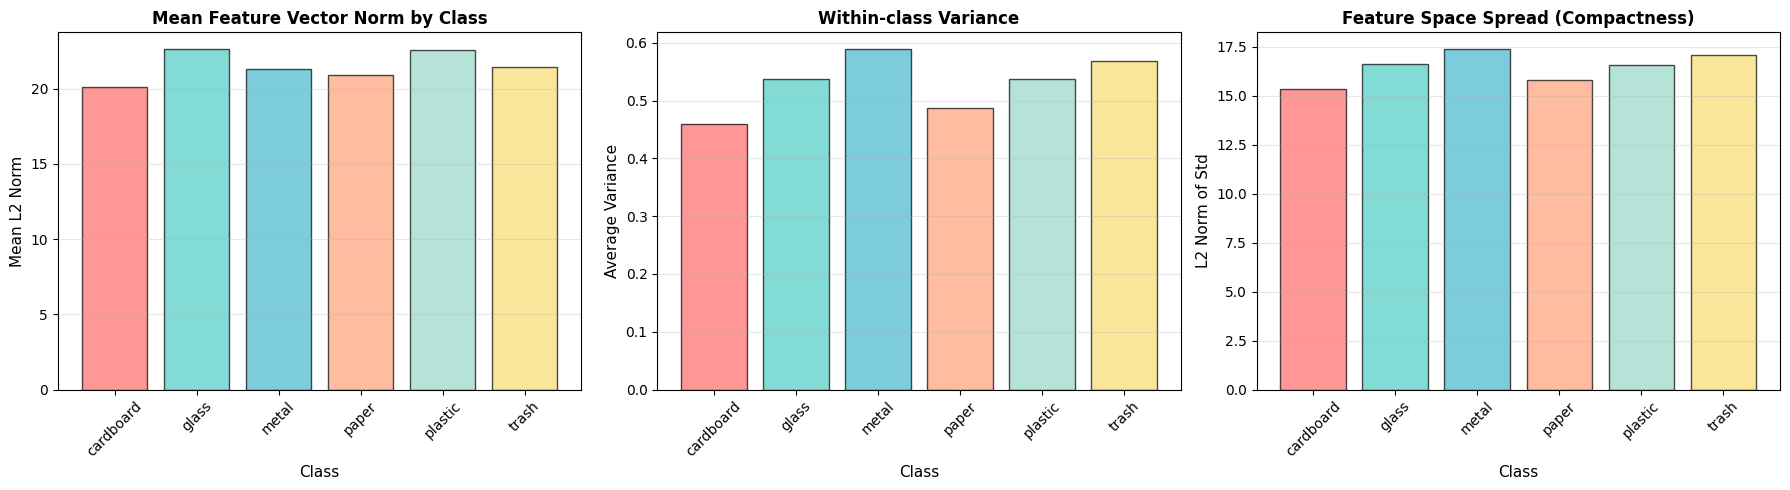


Detailed Class Statistics:
Class        N      Mean Norm    Within Var   Spread      
------------------------------------------------------------
cardboard    403    20.1022      0.4601       15.3479     
glass        501    22.6029      0.5378       16.5934     
metal        410    21.2708      0.5886       17.3592     
paper        594    20.8961      0.4868       15.7872     
plastic      482    22.5608      0.5370       16.5821     
trash        137    21.4019      0.5688       17.0660     

Compactness Analysis:
  Most compact class: cardboard (var=0.4601)
  Least compact class: metal (var=0.5886)
  Compactness ratio: 1.28x

✓ Within-class variance analysis saved: 02_within_class_variance.png


In [19]:
# Cell 12: Within-class Variance Analysis  
print("\n" + "="*60)  
print("WITHIN-CLASS VARIANCE ANALYSIS")  
print("="*60)  

# Calculate within-class statistics  
class_stats = []  

for i, class_name in enumerate(class_names):  
    class_mask = true_labels == i  
    class_features = resnet_features[class_mask]  
    
    # Calculate statistics  
    mean_vector = class_features.mean(axis=0)  
    std_vector = class_features.std(axis=0)  
    
    within_class_var = np.mean(std_vector**2)  # Average variance across dimensions  
    feature_spread = np.linalg.norm(std_vector)  # L2 norm of std  
    
    class_stats.append({  
        'class': class_name,  
        'n_samples': len(class_features),  
        'mean_norm': np.linalg.norm(mean_vector),  
        'within_var': within_class_var,  
        'spread': feature_spread  
    })  

# Create DataFrame for easy visualization  
import pandas as pd  
stats_df = pd.DataFrame(class_stats)  

# Visualize  
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  

# Plot 1: Mean L2 Norm  
axes[0].bar(stats_df['class'], stats_df['mean_norm'],   
            color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F'],  
            edgecolor='black', alpha=0.7)  
axes[0].set_title('Mean Feature Vector Norm by Class',   
                  fontsize=12, fontweight='bold')  
axes[0].set_xlabel('Class', fontsize=11)  
axes[0].set_ylabel('Mean L2 Norm', fontsize=11)  
axes[0].tick_params(axis='x', rotation=45)  
axes[0].grid(alpha=0.3, axis='y')  

# Plot 2: Within-class Variance  
axes[1].bar(stats_df['class'], stats_df['within_var'],   
            color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F'],  
            edgecolor='black', alpha=0.7)  
axes[1].set_title('Within-class Variance',   
                  fontsize=12, fontweight='bold')  
axes[1].set_xlabel('Class', fontsize=11)  
axes[1].set_ylabel('Average Variance', fontsize=11)  
axes[1].tick_params(axis='x', rotation=45)  
axes[1].grid(alpha=0.3, axis='y')  

# Plot 3: Feature Spread  
axes[2].bar(stats_df['class'], stats_df['spread'],   
            color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F'],  
            edgecolor='black', alpha=0.7)  
axes[2].set_title('Feature Space Spread (Compactness)',   
                  fontsize=12, fontweight='bold')  
axes[2].set_xlabel('Class', fontsize=11)  
axes[2].set_ylabel('L2 Norm of Std', fontsize=11)  
axes[2].tick_params(axis='x', rotation=45)  
axes[2].grid(alpha=0.3, axis='y')  

plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/02_within_class_variance.png',   
            dpi=300, bbox_inches='tight')  
plt.show()  

# Print detailed statistics  
print("\nDetailed Class Statistics:")  
print(f"{'Class':<12} {'N':<6} {'Mean Norm':<12} {'Within Var':<12} {'Spread':<12}")  
print("-" * 60)  
for stat in class_stats:  
    print(f"{stat['class']:<12} {stat['n_samples']:<6} "  
          f"{stat['mean_norm']:<12.4f} {stat['within_var']:<12.4f} "  
          f"{stat['spread']:<12.4f}")  

# Identify most/least compact classes  
most_compact = min(class_stats, key=lambda x: x['within_var'])  
least_compact = max(class_stats, key=lambda x: x['within_var'])  

print(f"\nCompactness Analysis:")  
print(f"  Most compact class: {most_compact['class']} (var={most_compact['within_var']:.4f})")  
print(f"  Least compact class: {least_compact['class']} (var={least_compact['within_var']:.4f})")  
print(f"  Compactness ratio: {least_compact['within_var'] / most_compact['within_var']:.2f}x")  

print("\n✓ Within-class variance analysis saved: 02_within_class_variance.png")  
print("="*60)  


PRELIMINARY OUTLIER DETECTION
Outlier Detection Results:
  Threshold (95th percentile): 20.1600
  Number of outliers: 127/2527
  Percentage: 5.03%

Outliers by Class:
Class        Outliers   Total    Percentage
---------------------------------------------
cardboard    11         403        2.73%
glass        22         501        4.39%
metal        41         410       10.00%
paper        20         594        3.37%
plastic      27         482        5.60%
trash        6          137        4.38%


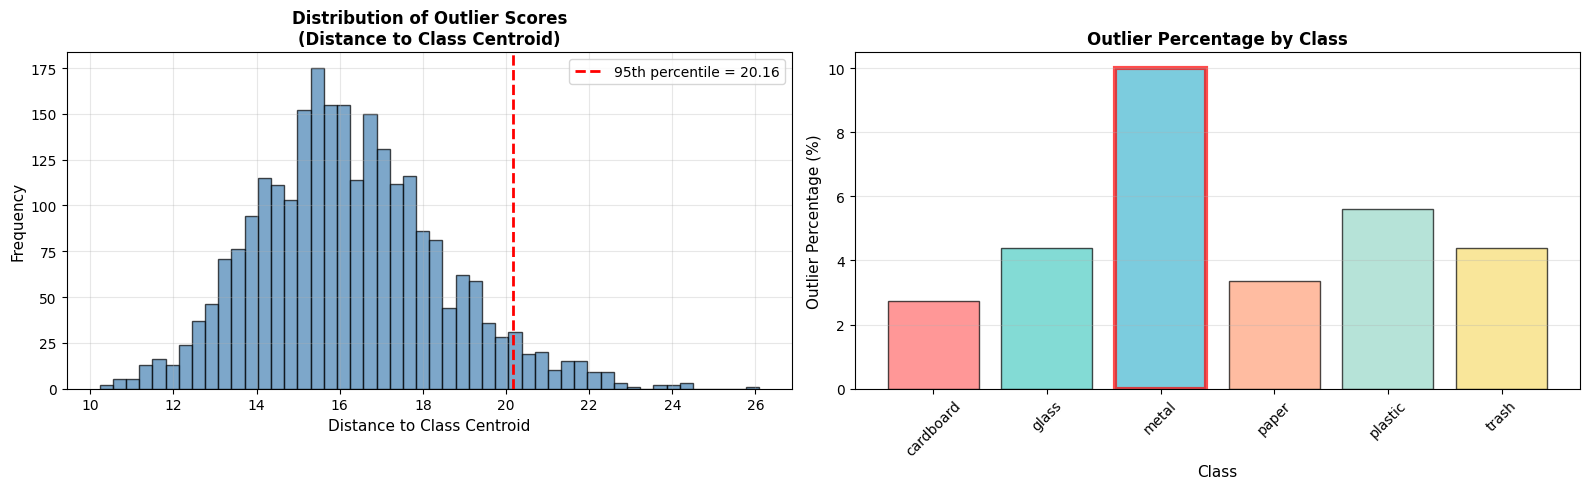


 Outlier detection saved:
  - 02_outlier_detection.png
  - outlier_info.npy (for Notebook 8)


In [20]:
# Cell 13: Preliminary Outlier Detection  
print("\n" + "="*60)  
print("PRELIMINARY OUTLIER DETECTION")  
print("="*60)  

# Method 1: Distance to class centroid  
outlier_scores = []  
for i in range(len(resnet_features)):  
    sample_feature = resnet_features[i]  
    sample_label = true_labels[i]  
    class_centroid = class_centroids[sample_label]  
    
    # Euclidean distance to own class centroid  
    distance = np.linalg.norm(sample_feature - class_centroid)  
    outlier_scores.append(distance)  

outlier_scores = np.array(outlier_scores)  

# Identify top outliers (95th percentile)  
threshold = np.percentile(outlier_scores, 95)  
outlier_mask = outlier_scores > threshold  

print(f"Outlier Detection Results:")  
print(f"  Threshold (95th percentile): {threshold:.4f}")  
print(f"  Number of outliers: {outlier_mask.sum()}/{len(resnet_features)}")  
print(f"  Percentage: {outlier_mask.sum()/len(resnet_features)*100:.2f}%")  

# Outliers by class  
print("\nOutliers by Class:")  
print(f"{'Class':<12} {'Outliers':<10} {'Total':<8} {'Percentage':<10}")  
print("-" * 45)  
for i, class_name in enumerate(class_names):  
    class_mask = true_labels == i  
    class_outliers = (outlier_mask & class_mask).sum()  
    class_total = class_mask.sum()  
    percentage = class_outliers / class_total * 100  
    print(f"{class_name:<12} {class_outliers:<10} {class_total:<8} {percentage:>6.2f}%")  

# Visualize  
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  

# Plot 1: Outlier score distribution  
axes[0].hist(outlier_scores, bins=50, color='steelblue',   
             alpha=0.7, edgecolor='black')  
axes[0].axvline(threshold, color='red', linestyle='--',   
                linewidth=2, label=f'95th percentile = {threshold:.2f}')  
axes[0].set_title('Distribution of Outlier Scores\n(Distance to Class Centroid)',   
                  fontsize=12, fontweight='bold')  
axes[0].set_xlabel('Distance to Class Centroid', fontsize=11)  
axes[0].set_ylabel('Frequency', fontsize=11)  
axes[0].legend(fontsize=10)  
axes[0].grid(alpha=0.3)  

# Plot 2: Outlier percentage by class  
outlier_percentages = []  
for i in range(len(class_names)):  
    class_mask = true_labels == i  
    class_outliers = (outlier_mask & class_mask).sum()  
    class_total = class_mask.sum()  
    outlier_percentages.append(class_outliers / class_total * 100)  

bars = axes[1].bar(class_names, outlier_percentages,   
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F'],  
                   edgecolor='black', alpha=0.7)  
axes[1].set_title('Outlier Percentage by Class',   
                  fontsize=12, fontweight='bold')  
axes[1].set_xlabel('Class', fontsize=11)  
axes[1].set_ylabel('Outlier Percentage (%)', fontsize=11)  
axes[1].tick_params(axis='x', rotation=45)  
axes[1].grid(alpha=0.3, axis='y')  

# Highlight class with most outliers  
max_idx = np.argmax(outlier_percentages)  
bars[max_idx].set_edgecolor('red')  
bars[max_idx].set_linewidth(3)  

plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/02_outlier_detection.png',   
            dpi=300, bbox_inches='tight')  
plt.show()  

# Save outlier information for Notebook 8  
outlier_info = {  
    'outlier_scores': outlier_scores,  
    'outlier_mask': outlier_mask,  
    'threshold': threshold  
}  
np.save(f'{OUTPUT_DIR}/outlier_info.npy', outlier_info, allow_pickle=True)  

print("\n Outlier detection saved:")  
print("  - 02_outlier_detection.png")  
print("  - outlier_info.npy (for Notebook 8)")  
print("="*60)  